In [1]:
%%capture
!pip install -Uqq fastai gradio
!apt -get install tree

In [3]:
!conda install pyarrow
!pip install pydicom kornia opencv-python scikit-image nbdev

/bin/bash: line 1: conda: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.4 MB/s eta 0:00:00


In [4]:
from fastai.vision.all import*
from fastai import *
from torch import nn,optim
import torch

from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *

import pydicom

import pandas as pd

In [5]:
path=untar_data(URLs.SIIM_SMALL)

In [6]:
data=get_dicom_files(path/f"train/")

In [7]:
train,val=RandomSplitter()(data)

In [8]:
patient=7
x_ray_sample=data[patient].dcmread()

In [9]:
x_ray_sample

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.3355.1517875177.462118
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.3355.1517875177.462118
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

In [10]:
x_ray_sample.PixelData[:200]

b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00\xe0\x16\xfe\x01\x00\xff\xd8\xff\xdb\x00C\x00\x03\x02\x02\x02\x02\x02\x03\x02\x02\x02\x03\x03\x03\x03\x04\x06\x04\x04\x04\x04\x04\x08\x06\x06\x05\x06\t\x08\n\n\t\x08\t\t\n\x0c\x0f\x0c\n\x0b\x0e\x0b\t\t\r\x11\r\x0e\x0f\x10\x10\x11\x10\n\x0c\x12\x13\x12\x10\x13\x0f\x10\x10\x10\xff\xc0\x00\x0b\x08\x04\x00\x04\x00\x01\x01\x11\x00\xff\xc4\x00\x1d\x00\x00\x02\x03\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x04\x05\x02\x03\x06\x01\x00\x07\x08\t\xff\xc4\x00d\x10\x00\x01\x03\x03\x03\x02\x04\x02\x06\x03\x06\x0f\x0b\n\x03\t\x01\x02\x03\x11\x00\x04!\x05\x121AQ\x06\x13"a2q\x07\x14#\x81\x91\xa1B\xb1\xd2\x153R\x95\xc1\xd1\x16\x17$%&STbr\x92\x93\xb2\xb3\xb4\xe1'

In [11]:
x_ray_sample.pixel_array, x_ray_sample.pixel_array.shape

(array([[ 50, 100,  81, ...,  38,  43,  21],
        [112, 177, 165, ...,  74,  75,  50],
        [ 98, 168, 157, ...,  66,  66,  39],
        ...,
        [ 38,  61,  54, ...,  20,  21,  13],
        [ 40,  60,  53, ...,  21,  22,  13],
        [ 15,  34,  26, ...,  11,  12,   3]], dtype=uint8),
 (1024, 1024))

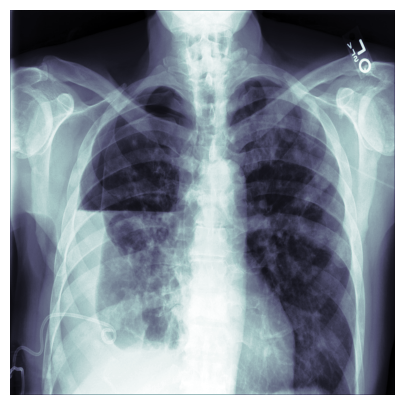

In [12]:
x_ray_sample.show()

In [13]:
dicom_df=pd.DataFrame.from_dicoms(data)
dicom_df[:5]

,SpecificCharacterSet,SOPClassUID,SOPInstanceUID,StudyDate,StudyTime,AccessionNumber,Modality,ConversionType,ReferringPhysicianName,SeriesDescription,...,HighBit,PixelRepresentation,LossyImageCompression,LossyImageCompressionMethod,fname,img_min,img_max,img_mean,img_std,img_pct_window
0,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.4188.1517875181.583930,19010101,000000.00,,CR,WSD,(),view: PA,...,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/Pneumothorax/000129.dcm,0,252,181.843106,52.641022,0.050046
1,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.1947.1517875170.376982,19010101,000000.00,,CR,WSD,(),view: PA,...,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/Pneumothorax/000070.dcm,0,236,138.091617,65.289939,0.197852
2,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.5674.1517875189.430619,19010101,000000.00,,CR,WSD,(),view: AP,...,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/Pneumothorax/000161.dcm,1,235,158.310349,44.844662,0.064774
3,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.4847.1517875185.102088,19010101,000000.00,,CR,WSD,(),view: PA,...,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/Pneumothorax/000189.dcm,0,255,162.344687,55.083642,0.083199
4,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.10016.1517875220.992175,19010101,000000.00,,CR,WSD,(),view: PA,...,7,0,01,ISO_10918_1,/root/.fastai/data/siim_small/train/Pneumothorax/000004.dcm,0,244,127.429303,67.677215,0.148414


In [14]:
df=pd.read_csv(path/f"labels.csv")
df.head()

,file,label
0,train/No Pneumothorax/000000.dcm,No Pneumothorax
1,train/Pneumothorax/000001.dcm,Pneumothorax
2,train/No Pneumothorax/000002.dcm,No Pneumothorax
3,train/Pneumothorax/000003.dcm,Pneumothorax
4,train/Pneumothorax/000004.dcm,Pneumothorax


In [15]:
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
                   get_x=lambda x:path/f"{x[0]}",
                   get_y=lambda x:x[1],
                   batch_tfms=[*aug_transforms(size=224),Normalize.from_stats(*imagenet_stats)])

dls = pneumothorax.dataloaders(df.values, num_workers=0)

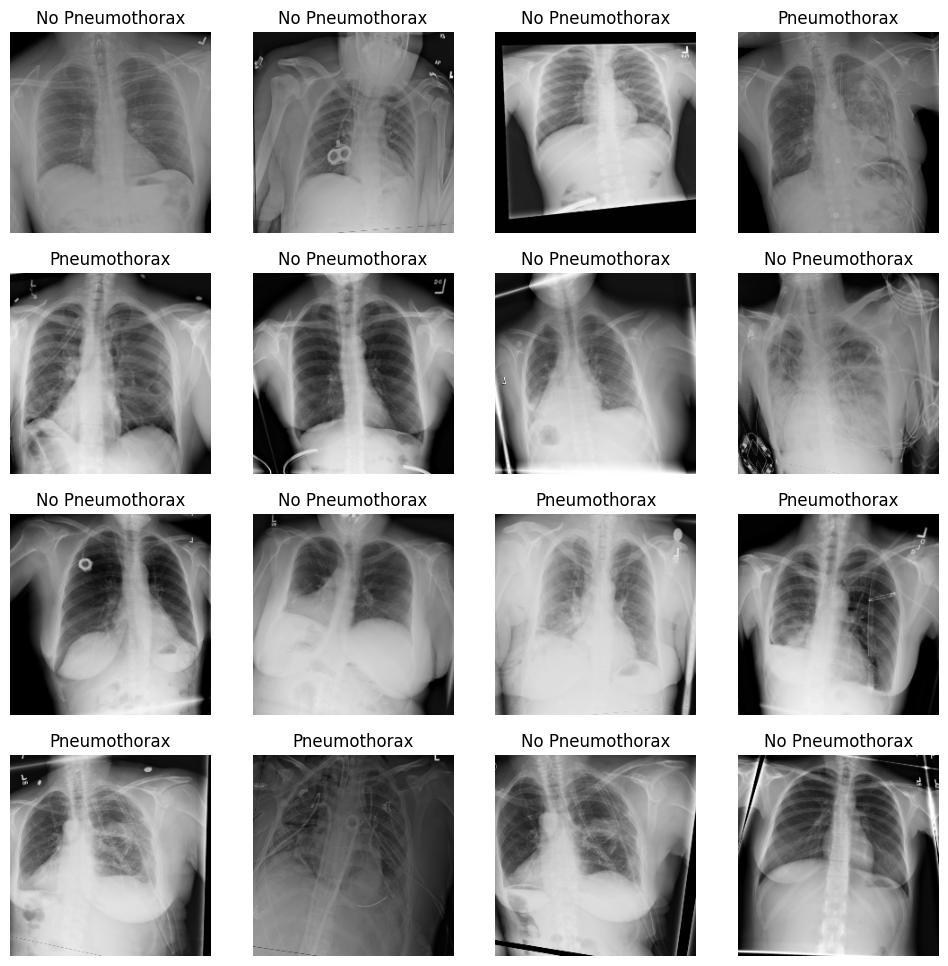

In [16]:
dls = pneumothorax.dataloaders(df.values)
dls.show_batch(max_n=16)

In [17]:
learn=vision_learner(dls,resnet34,metrics=accuracy)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 69.3MB/s]


In [18]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [19]:
learn.opt_func

<function fastai.optimizer.Adam(params: 'Tensor | Iterable', lr: 'float | slice', mom: 'float' = 0.9, sqr_mom: 'float' = 0.99, eps: 'float' = 1e-05, wd: 'Real' = 0.01, decouple_wd: 'bool' = True) -> 'Optimizer'>

SuggestedLRs(valley=0.0014454397605732083)

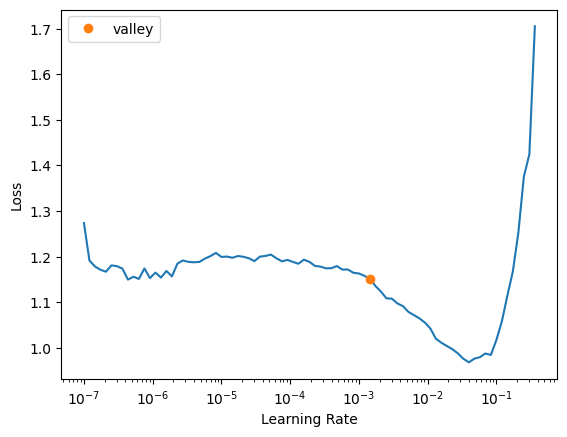

In [20]:
learn.lr_find()

In [21]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.248774,0.789157,0.640000,01:23
1,1.237402,0.637200,0.680000,01:19
2,1.149619,0.575735,0.780000,01:22
3,1.105704,0.529203,0.700000,01:19
4,1.056245,0.544872,0.640000,01:21
5,1.003985,0.544520,0.700000,01:22
6,0.969123,0.565363,0.720000,01:19
7,0.942953,0.589068,0.760000,01:22
8,0.925391,0.603314,0.760000,01:19
9,0.887289,0.595165,0.760000,01:21
